In [1]:
pip install scikit-learn numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Load Data
print("Loading MNIST data... (this might take a minute)")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# Subset for speed? (Optional: Uncomment next line to use only 10k samples for testing code)
# X, y = X[:10000], y[:10000]

# 2. Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Scale Data (Crucial for PCA and ANN/SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Create PCA Dataset
# Retain 95% of variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original feature count: {X_train_scaled.shape[1]}")
print(f"PCA feature count (95% variance): {X_train_pca.shape[1]}")

Loading MNIST data... (this might take a minute)
Original feature count: 784
PCA feature count (95% variance): 330


In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import time

# Define models
models = {
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=50),
    "SVM": SVC(kernel='rbf'), # RBF is standard for MNIST
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=200, solver='lbfgs'),
    "Classification Tree": DecisionTreeClassifier()
}

def evaluate_models(dataset_name, X_tr, X_te, y_tr, y_te):
    print(f"\n--- Results for {dataset_name} Dataset ---")
    for name, model in models.items():
        start_time = time.time()
        
        # Train
        model.fit(X_tr, y_tr)
        
        # Predict
        pred = model.predict(X_te)
        
        # Evaluate
        acc = accuracy_score(y_te, pred)
        duration = time.time() - start_time
        
        print(f"{name}: Accuracy = {acc:.4f} (Time: {duration:.2f}s)")

# Run on Full Dataset (Scaled)
evaluate_models("FULL (Scaled)", X_train_scaled, X_test_scaled, y_train, y_test)

# Run on PCA Dataset
evaluate_models("PCA (Compressed)", X_train_pca, X_test_pca, y_train, y_test)


--- Results for FULL (Scaled) Dataset ---
Neural Network: Accuracy = 0.9723 (Time: 12.35s)
SVM: Accuracy = 0.9630 (Time: 312.64s)
K-Nearest Neighbors: Accuracy = 0.9458 (Time: 7.08s)
Logistic Regression: Accuracy = 0.9159 (Time: 14.05s)
Classification Tree: Accuracy = 0.8733 (Time: 11.24s)

--- Results for PCA (Compressed) Dataset ---


/opt/homebrew/Caskroom/miniconda/base/envs/CS-3600/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network: Accuracy = 0.9687 (Time: 8.17s)
SVM: Accuracy = 0.9644 (Time: 161.86s)
K-Nearest Neighbors: Accuracy = 0.9497 (Time: 2.33s)


/opt/homebrew/Caskroom/miniconda/base/envs/CS-3600/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: Accuracy = 0.9220 (Time: 8.34s)
Classification Tree: Accuracy = 0.8181 (Time: 40.83s)



--- K-Means on FULL Data ---
Homogeneity Score: 0.4218

--- K-Means on PCA Data ---
Homogeneity Score: 0.4225


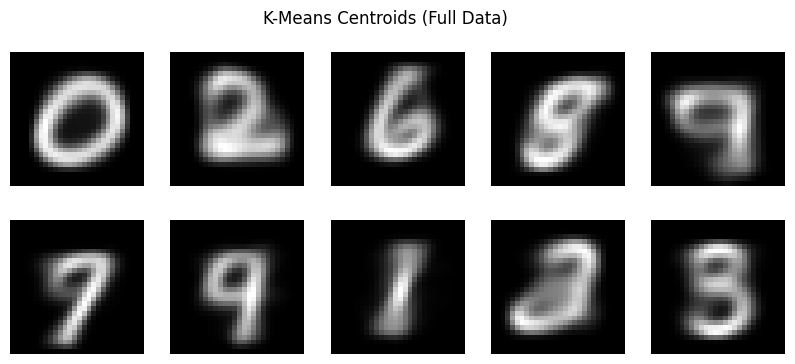

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score

def run_clustering(dataset_name, X_data, y_true):
    print(f"\n--- K-Means on {dataset_name} ---")
    
    # We look for 10 clusters (digits 0-9)
    kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
    kmeans.fit(X_data)
    
    # Metrics
    # Homogeneity: Each cluster contains only members of a single class
    h_score = homogeneity_score(y_true, kmeans.labels_)
    
    print(f"Homogeneity Score: {h_score:.4f}")
    
    return kmeans

# Run on Full Data
kmeans_full = run_clustering("FULL Data", X_train_scaled, y_train)

# Run on PCA Data
kmeans_pca = run_clustering("PCA Data", X_train_pca, y_train)

# Optional: Visualize the centers (What does the machine think the 'average' digit looks like?)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
centers = scaler.inverse_transform(kmeans_full.cluster_centers_) # Un-scale to see images
for ax, center in zip(axes.ravel(), centers):
    ax.imshow(center.reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.suptitle("K-Means Centroids (Full Data)")
plt.show()


--- Logistic Regression Weights (The 'Templates') ---


ValueError: cannot reshape array of size 3300 into shape (10,28,28)

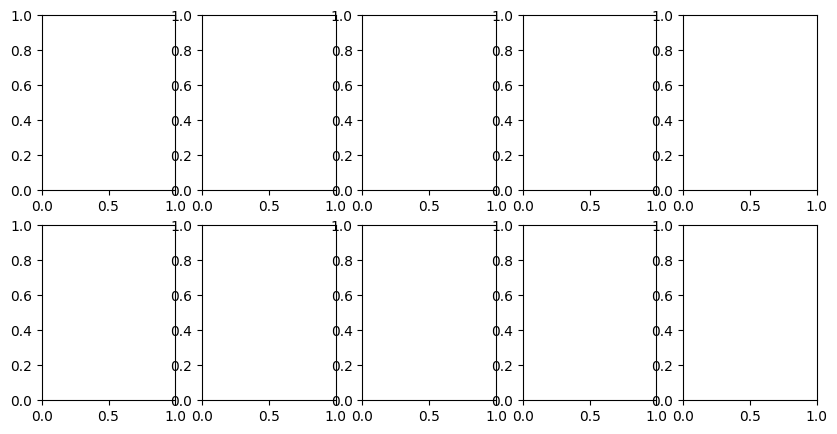

In [5]:
import matplotlib.pyplot as plt
from sklearn import tree

def visualize_model_internals(models_dict, X_train, y_train, X_test):
    """
    Visualizes the internal workings of specific models.
    """
    
    # --- 1. Visualize Logistic Regression Weights ---
    # This shows the "ghostly" templates the model matched against the digits
    if "Logistic Regression" in models_dict:
        model = models_dict["Logistic Regression"]
        print("\n--- Logistic Regression Weights (The 'Templates') ---")
        
        fig, axes = plt.subplots(2, 5, figsize=(10, 5))
        coefs = model.coef_.reshape(10, 28, 28) # Reshape 784 weights back to 28x28
        
        for i, ax in enumerate(axes.ravel()):
            ax.imshow(coefs[i], cmap='seismic', vmin=-0.5, vmax=0.5)
            ax.set_title(f"Digit {i}")
            ax.axis('off')
        plt.show()

    # --- 2. Visualize Decision Tree Logic ---
    # This draws the top few decisions the tree makes
    if "Classification Tree" in models_dict:
        model = models_dict["Classification Tree"]
        print("\n--- Decision Tree (Top 3 Levels) ---")
        
        plt.figure(figsize=(20, 8))
        tree.plot_tree(model, max_depth=3, feature_names=[f"px_{i}" for i in range(784)], 
                       class_names=[str(i) for i in range(10)], filled=True, fontsize=10)
        plt.show()

    # --- 3. Visualize KNN (Query vs Neighbors) ---
    # Shows a test digit and the 5 closest training digits that voted on it
    if "K-Nearest Neighbors" in models_dict:
        model = models_dict["K-Nearest Neighbors"]
        print("\n--- KNN: Test Image vs. 5 Nearest Neighbors ---")
        
        # Pick a random test image
        test_idx = 0 
        distances, indices = model.kneighbors(X_test[test_idx].reshape(1, -1))
        
        fig, axes = plt.subplots(1, 6, figsize=(12, 3))
        
        # Plot Test Image
        axes[0].imshow(X_test[test_idx].reshape(28, 28), cmap='gray')
        axes[0].set_title("Test Image")
        axes[0].axis('off')
        
        # Plot Neighbors
        for i, neighbor_idx in enumerate(indices[0]):
            axes[i+1].imshow(X_train[neighbor_idx].reshape(28, 28), cmap='gray')
            axes[i+1].set_title(f"Neighbor {i+1}")
            axes[i+1].axis('off')
        plt.show()

# NOTE: You must run this using the "Full" (not PCA) models for the images to make sense!
# Pass the dictionary of trained models from Part 2 here:
visualize_model_internals(models, X_train_scaled, y_train, X_test_scaled)

In [ ]:
import pandas as pd
import seaborn as sns

# 1. Container to store results
results = []

def train_and_log(dataset_name, X_tr, X_te, y_tr, y_te):
    for name, model in models.items():
        start = time.time()
        model.fit(X_tr, y_tr)
        end = time.time()
        
        acc = model.score(X_te, y_te)
        time_taken = end - start
        
        results.append({
            "Model": name,
            "Dataset": dataset_name,
            "Accuracy": acc,
            "Time (s)": time_taken
        })
        print(f"{dataset_name} - {name}: {acc:.4f} in {time_taken:.2f}s")

# Run training (as before)
train_and_log("Full Data", X_train_scaled, X_test_scaled, y_train, y_test)
train_and_log("PCA Data", X_train_pca, X_test_pca, y_train, y_test)

# 2. Visualize Performance
df_results = pd.DataFrame(results)

plt.figure(figsize=(12, 6))

# Scatter plot: Time vs Accuracy
sns.scatterplot(data=df_results, x="Time (s)", y="Accuracy", hue="Dataset", style="Model", s=200)

plt.title("Model Performance: Accuracy vs Training Time", fontsize=16)
plt.xscale('log') # Log scale because SVM/KNN might take 100x longer than Logistic Regression
plt.xlabel("Training Time (seconds) - Log Scale", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()